In [2]:
using Pkg, Plots, TOML, UnPack, Test, LinearAlgebra, Revise, PlotlyBase, Statistics
using GLM, DataFrames, CSV

In [3]:
includet("MD_Simulation.jl")
using .MD_Simulation

In [ ]:
using .MD_Simulation.HardSpheres: hard_spheres
using .MD_Simulation.MolecularDynamics: VelocityVerlet, vv_initialize!, vv_integrate!, vv_finalize!
using .MD_Simulation.Accessors: box_length, positions, velocities, forces, masses, number_of_particles
using .MD_Simulation.RDF: rdf, rdf_initialize!, rdf_compute!, rdf_finalize!
using .MD_Simulation.ForceFields: LennardJones
using .MD_Simulation.MD_utils: plot_particles_with_box

## Initial Simulation

In [56]:
# Setup  

# initialize with rho* = 0.8, T* = 1.5; initialize with nondimensionalized parameters
ϕ= π*0.8/6
target_temperature = 1.5
dt = 0.001
parameters = Dict(:ε => 1.0, :σ => 1.0, :rcut => 2.5)

# Define the system and force field 
system = hard_spheres(N=256, ϕ=ϕ, lattice="fcc")
forcefield = LennardJones(system, parameters)

# 100 bins with maximum radius set to half the box length for RDF 
rdf_calc = rdf(bins=100, r_max=0.5 * box_length(system))

# Initialize system
thermostat_frequency = 100  # Only rescale every 100 steps
integrator = VelocityVerlet(dt, system, forcefield, target_temperature, thermostat_frequency)
vv_initialize!(integrator, system, forcefield, dt, target_temperature, thermostat_frequency)

0

In [57]:
plotly()
plot_particles_with_box(positions(system), box_length(system))

┌ Warning: Failed to load integration with PlotlyBase & PlotlyKaleido.
│   exception = (ArgumentError("Package PlotlyKaleido not found in current path.\n- Run `import Pkg; Pkg.add(\"PlotlyKaleido\")` to install the PlotlyKaleido package."), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007ff91ccf455a, Ptr{Nothing} @0x00007ff91bfd9064, Ptr{Nothing} @0x00007ff93f8696fe, Ptr{Nothing} @0x00007ff91bcff3e6, Ptr{Nothing} @0x00007ff91bcff444, Ptr{Nothing} @0x00007ff93f899b92, Ptr{Nothing} @0x00007ff93f89ba66, Ptr{Nothing} @0x00007ff93f87dafa, Ptr{Nothing} @0x00007ff93f87e31e, Base.InterpreterIP in top-level CodeInfo for Main at statement 1, Ptr{Nothing} @0x00007ff93f89adb8, Ptr{Nothing} @0x00007ff93f89c536, Ptr{Nothing} @0x00000183d7bc676e, Ptr{Nothing} @0x00000183d7bc6f68, Ptr{Nothing} @0x00000183d7bc70b6, Ptr{Nothing} @0x00000183d7bc70e4, Ptr{Nothing} @0x00007ff93f87cc7a, Ptr{Nothing} @0x00007ff93f87c774, Ptr{Nothing} @0x00007ff93f87d3c0, Ptr{Nothing} @0x00007ff93f87e31e, Base.In

In [ ]:
prod_time = 10000
# Equilibration run with no RDF calculation
println("Starting equilibration...")
vv_integrate!(integrator, 5000)

# Production run with RDF calculation every 10 steps
rdf_initialize!(rdf_calc, system)
integrator.thermostat_frequency = prod_time # kill temperature recalbriations
println("Starting production run...")
run_md_with_rdf!(integrator, rdf_calc, prod_time, 10)
rdf_finalize!(rdf_calc)

# Plot RDF results
rdf_data = DataFrame(
    r = [(i-0.5)*rdf_calc.dr for i in 1:rdf_calc.bins],
    g_r = rdf_calc.hist)

plot(rdf_data.r, rdf_data.g_r, 
     xlabel="r/σ", ylabel="g(r)", 
     title="Radial Distribution Function",
     linewidth=2, legend=false)

# Simulate for Constant T*, varying $\rho^*$

In [5]:
# b) plot g(r) for T* = 1.5 and rho* = 0.6 - 1.0 in increments of 0.1
# Set up integrator
ϕ_diff = [π*ρ/6 for ρ in 0.6:0.1:1.0]
target_temperature = 1.5
dt = 0.001
equilibration_steps = 5000
production_steps = 10000
thermostat_frequency = 100  # rescale every 100 steps
parameters = Dict(:ε => 1.0, :σ => 1.0, :rcut => 2.5)

# Store RDF results for each temp
results = Dict()

# Current density (starting point)
current_density = ϕ_diff[1]
for density in ϕ_diff
    println("Processing density: $density")
    # Create system and force field
    b_system = hard_spheres(N=256, ϕ=density, lattice="fcc")
    forcefield = LennardJones(b_system, parameters)
    integrator = VelocityVerlet(dt, b_system, forcefield, target_temperature, thermostat_frequency)
    println("Equilibrating system at initial temp: $density)")
    vv_initialize!(integrator, b_system, forcefield, dt, target_temperature, thermostat_frequency)
    vv_integrate!(integrator, equilibration_steps)
    
    # Production run and RDF calculation
    println("Starting production run for RDF calculation")
    # Create and initialize RDF calculator
    rdf_calc = rdf(bins=100, r_max=0.5 * box_length(b_system))
    rdf_initialize!(rdf_calc, b_system)

    println("Starting production run...")
    run_md_with_rdf!(integrator, rdf_calc, 5000, 10)
    rdf_finalize!(rdf_calc)
    # store data
    current_results = deepcopy(rdf_calc)
    results[temp] = DataFrame(r = [(i-0.5)*current_results.dr for i in 1:current_results.bins], g_r = current_results.hist)
end

Processing density: 0.3141592653589793
Equilibrating system at initial density: 0.3141592653589793)
Step: 100, Temp: 1.4999999999999998, KE: 575.9999999999998, PE: -1017.1388154515063, Virial: 1763.365237188512
Step: 200, Temp: 1.500000000000001, KE: 576.0000000000001, PE: -955.6235927136828, Virial: -783.4321691061372
Step: 300, Temp: 1.4999999999999984, KE: 575.9999999999997, PE: -923.739910023703, Virial: -1342.0133767059076
Step: 400, Temp: 1.4999999999999991, KE: 575.9999999999999, PE: -927.0183262466855, Virial: -2127.5431219184047
Step: 500, Temp: 1.5, KE: 576.0000000000001, PE: -943.3127290072962, Virial: -1942.3349520767767
Step: 600, Temp: 1.4999999999999973, KE: 575.9999999999997, PE: -946.3610133815782, Virial: -1035.6214943888062
Step: 700, Temp: 1.4999999999999998, KE: 576.0, PE: -932.4790855783223, Virial: -1893.6732901597068
Step: 800, Temp: 1.5000000000000009, KE: 576.0000000000003, PE: -943.890460322629, Virial: -1108.9385745445663
Step: 900, Temp: 1.4999999999999984,

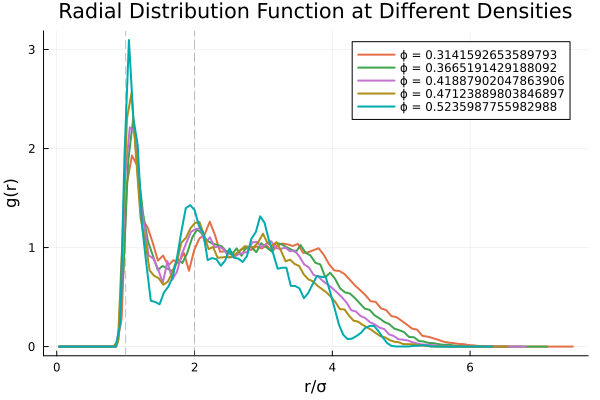

"c:\\Users\\noahs\\work\\chem5555_Modules3-7\\Module_4\\rdf_multiple_densities.png"

In [7]:
# Plotting RDF for b)i)
rdf_plot = plot(
    xlabel="r/σ", 
    ylabel="g(r)", 
    title="Radial Distribution Function at Different Densities",
    linewidth=2,
    legend=:topright  # Show legend at top right
)

# Reference lines for r = 1, 2
vline!([1, 2], linestyle=:dash, color=:gray, label="", alpha=0.5)

# Loop through densities
for density in ϕ_diff
        # Add this density's RDF to the plot with a unique color and label
    plot!(rdf_plot, results[density].r, results[density].g_r, 
          label="ϕ = $density", 
          linewidth=2)
end
# Display the updated plot
display(rdf_plot)
# Save the final plot if needed
savefig(rdf_plot, "rdf_multiple_densities.png")

# Part Two: Constant $\rho^*$, vary $T^*$

In [9]:
# make a second plot fixing rho* = 0.8 and varying T* from 1.5 to 5.0 in increments of 0.5
# Set up integrator
rho = 0.8
phi = π*rho/6
temp_diff = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
dt = 0.001
equilibration_steps = 5000
production_steps = 10000
thermostat_frequency = 100  # rescale every 100 steps
parameters = Dict(:ε => 1.0, :σ => 1.0, :rcut => 2.5)

# Store RDF results for each temp
results = Dict()

# Current temp (starting point)
current_temp = temp_diff[1]
for temp in temp_diff
    println("Processing temperature: $temp")
    # Create system and force field
    b_system = hard_spheres(N=256, ϕ=phi, lattice="fcc")
    forcefield = LennardJones(b_system, parameters)
    integrator = VelocityVerlet(dt, b_system, forcefield, temp, thermostat_frequency)
    println("Equilibrating system at initial temperature: $temp)")
    vv_initialize!(integrator, b_system, forcefield, dt, temp, thermostat_frequency)
    vv_integrate!(integrator, equilibration_steps)
    
    # Production run and RDF calculation
    println("Starting production run for RDF calculation")
    # Create and initialize RDF calculator
    rdf_calc = rdf(bins=100, r_max=0.5 * box_length(b_system))
    rdf_initialize!(rdf_calc, b_system)

    println("Starting production run...")
    run_md_with_rdf!(integrator, rdf_calc, 5000, 10)
    rdf_finalize!(rdf_calc)
    # store data
    current_results = deepcopy(rdf_calc)
    results[temp] = DataFrame(r = [(i-0.5)*current_results.dr for i in 1:current_results.bins], g_r = current_results.hist)
end

Processing temperature: 1.5
Equilibrating system at initial temperature: 1.5)
Step: 100, Temp: 1.5000000000000002, KE: 575.9999999999999, PE: -1434.585065128536, Virial: 1085.9059960263287
Step: 200, Temp: 1.4999999999999991, KE: 575.9999999999998, PE: -1301.879755811899, Virial: -2513.8289080596355
Step: 300, Temp: 1.5, KE: 576.0000000000003, PE: -1241.268991827762, Virial: -3423.9568604904716
Step: 400, Temp: 1.4999999999999984, KE: 575.9999999999995, PE: -1220.4662361449862, Virial: -4838.270764498225
Step: 500, Temp: 1.5000000000000009, KE: 576.0000000000002, PE: -1176.8829036821903, Virial: -2108.5396090967647
Step: 600, Temp: 1.4999999999999973, KE: 575.9999999999998, PE: -1241.28024734852, Virial: -3313.5476229189185
Step: 700, Temp: 1.499999999999999, KE: 576.0000000000001, PE: -1200.424811868261, Virial: -2390.8777610057164
Step: 800, Temp: 1.4999999999999984, KE: 575.9999999999993, PE: -1208.5226645729344, Virial: -3570.0913201071903
Step: 900, Temp: 1.5000000000000002, KE: 5

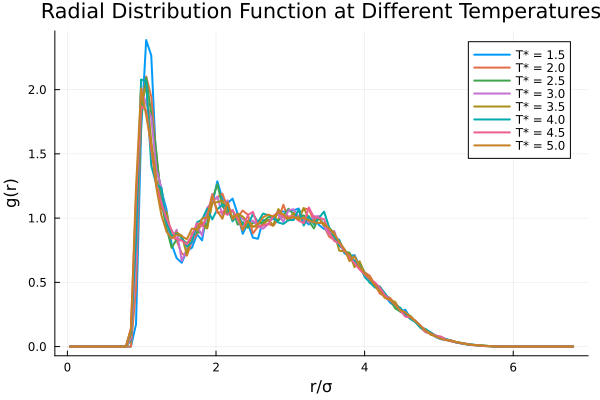

"c:\\Users\\noahs\\work\\chem5555_Modules3-7\\Module_4\\rdf_multiple_temp.png"

In [10]:
# Create an empty plot to start with
rdf_plot = plot(
    xlabel="r/σ", 
    ylabel="g(r)", 
    title="Radial Distribution Function at Different Temperatures",
    linewidth=2,
    legend=:topright  # Show legend at top right
)
# Loop through densities
for temp in temp_diff
        # Add this density's RDF to the plot with a unique color and label
    plot!(rdf_plot, results[temp].r, results[temp].g_r, 
          label="T* = $temp", 
          linewidth=2)
end
# Display the updated plot
display(rdf_plot)
# Save the final plot if needed
savefig(rdf_plot, "rdf_multiple_temp.png")

# Compute Plot Isotherms and Isochores

In [30]:
# c) using the virial equation, plot isotherms of P* vs. rho* and isochores P* vs. T*
# what fractional increase in pressure results in a 10% increase in density?
function calculate_pressure(ρ, T, virial_avg, system)
    # P* = ρ*T* + W/(3V)
    # where W is the virial and V is volume
    # virial_avg is the average virial per particle
    return ρ * T + virial_avg / (3 * box_length(system)^3)
end

temperatures = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]  # Range of reduced temperatures

8-element Vector{Float64}:
 1.5
 2.0
 2.5
 3.0
 3.5
 4.0
 4.5
 5.0

In [31]:
# same temp, diff densities
# Set up integrator
ϕ_diff = [π*ρ/6 for ρ in 0.6:0.1:1.0]
target_temperature = 1.5
dt = 0.001
equilibration_steps = 4000
production_steps = 6000
thermostat_frequency = 100  # rescale every 100 steps
parameters = Dict(:ε => 1.0, :σ => 1.0, :rcut => 2.5)

# Store RDF results for each temp
results = Dict()

# Current density (starting point)
current_density = ϕ_diff[1]
for density in ϕ_diff
    println("Processing packing density: $density")
    # Create system and force field
    b_system = hard_spheres(N=256, ϕ=density, lattice="fcc")
    forcefield = LennardJones(b_system, parameters)
    integrator = VelocityVerlet(dt, b_system, forcefield, target_temperature, thermostat_frequency)
    println("Equilibrating system at density: $density")
    vv_initialize!(integrator, b_system, forcefield, dt, target_temperature, thermostat_frequency)
    vv_integrate!(integrator, equilibration_steps)  

    println("Starting production run...")
    p_temp = zeros(Int(production_steps/20))
    for i in 1:Int(production_steps/20)
        vv_integrate!(integrator, 20)
        p_temp[i] = calculate_pressure(density, target_temperature, integrator.virial, integrator.system)
    end

    results[density] = p_temp
end

Processing packing density: 0.3141592653589793
Equilibrating system at density: 0.3141592653589793
Step: 100, Temp: 1.499999999999999, KE: 575.9999999999999, PE: -1038.1536206199162, Virial: 1052.7925886287976
Step: 200, Temp: 1.5000000000000002, KE: 576.0000000000002, PE: -917.8379163343604, Virial: -295.36587009108456
Step: 300, Temp: 1.4999999999999998, KE: 576.0000000000002, PE: -940.9445130374829, Virial: -683.4684257951329
Step: 400, Temp: 1.4999999999999991, KE: 575.9999999999995, PE: -947.1613389525015, Virial: -818.6664279996324
Step: 500, Temp: 1.5000000000000009, KE: 576.0000000000002, PE: -934.4189677363786, Virial: -649.1686319132389
Step: 600, Temp: 1.4999999999999984, KE: 575.9999999999994, PE: -948.693853730199, Virial: -356.9179019955538
Step: 700, Temp: 1.4999999999999984, KE: 576.0, PE: -921.8056167653514, Virial: -1175.0540266762337
Step: 800, Temp: 1.4999999999999993, KE: 575.9999999999998, PE: -930.2854774266815, Virial: -646.7681601868865
Step: 900, Temp: 1.49999

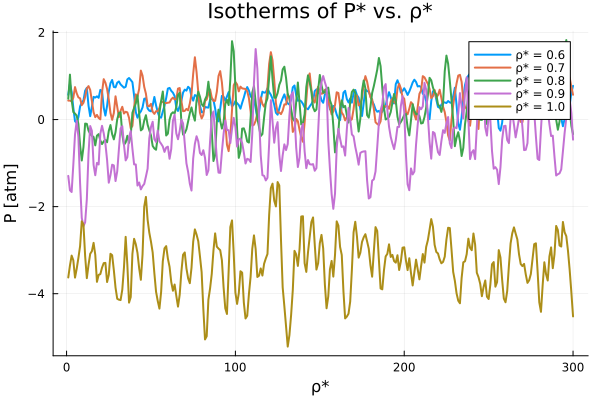

"c:\\Users\\noahs\\work\\chem5555_Modules3-7\\Module_4\\isotherms.png"

In [32]:
# Plotting isotherms of P* vs. ρ*
isotherms_plot = plot(
    xlabel="ρ*", 
    ylabel="P [atm]",
    title="Isotherms of P* vs. ρ*", 
    linewidth=2,
    legend=:topright  # Show legend at top right
)

# Loop through densities
for density in ϕ_diff
    rho = 6*density/π
    # Add this density's RDF to the plot with a unique color and label
    plot!(isotherms_plot, results[density], 
          label="ρ* = $rho", 
          linewidth=2)
end

display(isotherms_plot)
# Save the final plot 
savefig(isotherms_plot, "isotherms.png")

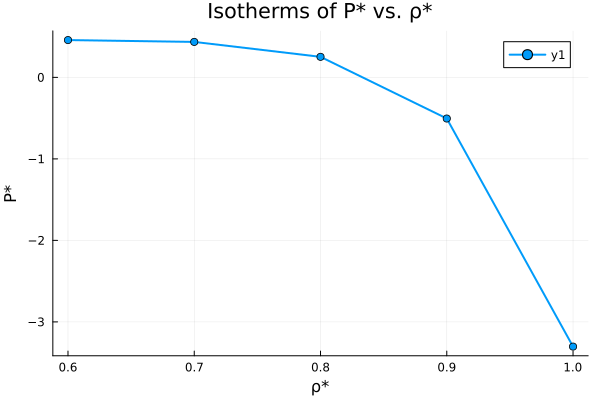

"c:\\Users\\noahs\\work\\chem5555_Modules3-7\\Module_4\\isotherms2.0.png"

In [33]:
# Plotting isotherms of P* vs. ρ*
isotherms_plot = plot(
    xlabel="ρ*", 
    ylabel="P*",  # Using reduced pressure units to match reduced density
    title="Isotherms of P* vs. ρ*", 
    linewidth=2,
    legend=:topright
)

densities = [6*density/π for density in ϕ_diff]  # Convert packing fractions to densities
mean_pressures = [mean(results[density]) for density in ϕ_diff]  # Get average pressure for each density

# Plot average pressure vs density
plot!(isotherms_plot, densities, mean_pressures, 
      marker=:circle,
      linewidth=2)

display(isotherms_plot)

savefig(isotherms_plot, "isotherms2.0.png")

In [52]:
# make a second plot fixing rho* = 0.8 and varying T* from 1.5 to 5.0 in increments of 0.5
# Set up integrator
rho = 0.8
phi = π*rho/6
temp_diff = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
dt = 0.001
equilibration_steps = 4000
production_steps = 6000
thermostat_frequency = 100  # rescale every 100 steps
parameters = Dict(:ε => 1.0, :σ => 1.0, :rcut => 2.5)

# Store results for each temp
results_t = Dict()

b_system = hard_spheres(N=256, ϕ=phi, lattice="fcc")
forcefield = LennardJones(b_system, parameters)

for temp in temp_diff
    println("Processing packing temp: $temp")
    # Create system and force field
    integrator = VelocityVerlet(dt, b_system, forcefield, temp, thermostat_frequency)
    println("Equilibrating system at density: $temp")
    vv_initialize!(integrator, b_system, forcefield, dt, temp, thermostat_frequency)
    vv_integrate!(integrator, equilibration_steps)  

    println("Starting production run...")
    p_temp_t = []
    for i in 1:(production_steps/10)
        vv_integrate!(integrator, 10)
        p = calculate_pressure(phi, temp, mean(integrator.virial), integrator.system)
        push!(p_temp_t, p)
    end

    results_t[temp] = p_temp_t
end

Processing packing temp: 1.5
Equilibrating system at density: 1.5
Step: 100, Temp: 1.5000000000000009, KE: 576.0000000000001, PE: -1441.470225920556, Virial: -125.3902000893622
Step: 200, Temp: 1.5, KE: 576.0000000000002, PE: -1286.7290031863151, Virial: -1718.372271420699
Step: 300, Temp: 1.4999999999999998, KE: 576.0000000000003, PE: -1246.0652501543188, Virial: -1831.0007225140482
Step: 400, Temp: 1.5000000000000009, KE: 576.0000000000001, PE: -1196.8413384703479, Virial: -1789.3112501503067
Step: 500, Temp: 1.5000000000000007, KE: 576.0000000000002, PE: -1217.6558931991005, Virial: -1491.2524320419207
Step: 600, Temp: 1.5000000000000016, KE: 576.0000000000003, PE: -1168.4538531946378, Virial: -1537.0748272461426
Step: 700, Temp: 1.5000000000000009, KE: 576.0000000000001, PE: -1163.6056484206954, Virial: -2297.6137391435063
Step: 800, Temp: 1.4999999999999993, KE: 576.0, PE: -1168.6457404101288, Virial: -1845.6857179001915
Step: 900, Temp: 1.5000000000000007, KE: 576.0, PE: -1177.75

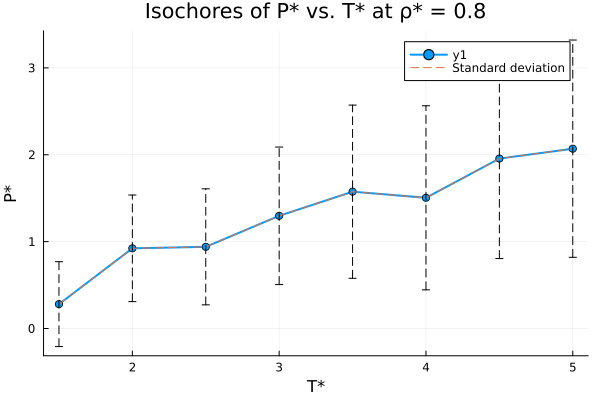

"c:\\Users\\noahs\\work\\chem5555_Modules3-7\\Module_4\\isochores.png"

In [55]:
# Plotting isochores of P* vs. T*
isochores_plot = plot(
    xlabel="T*", 
    ylabel="P*",
    title="Isochores of P* vs. T* at ρ* = 0.8", 
    linewidth=2,
    legend=:topright
)

# Calculate average pressure for each temperature
avg_pressures = [mean(results_t[temp]) for temp in temp_diff]

# Plot average pressure vs temperature
plot!(isochores_plot, temp_diff, avg_pressures, 
      marker=:circle,
      linewidth=2)

# Add error bars using standard deviation if needed
error_bars = [std(results_t[temp]) for temp in temp_diff]
plot!(isochores_plot, temp_diff, avg_pressures, 
      yerr=error_bars,
      linestyle=:dash,
      linewidth=1,
      label="Standard deviation")

display(isochores_plot)
savefig(isochores_plot, "isochores.png")

In [ ]:
# For the question: What fractional increase in pressure results in a 10% density change?
function calculate_pressure_change(T, ρ_initial, results_df)
    # Find the closest density that's approximately 10% higher
    ρ_target = ρ_initial * 1.1
    
    # Filter data for the given temperature
    temp_data = filter(row -> row.Temperature == T, results_df)
    
    # Find the initial pressure
    P_initial = temp_data[temp_data.Density .≈ ρ_initial, :Pressure][1]
    
    # Find the pressure at the higher density
    P_final = temp_data[temp_data.Density .≈ ρ_target, :Pressure][1]
    
    # Calculate fractional change
    fractional_change = (P_final - P_initial) / P_initial
    
    return fractional_change
end

# Calculate for a specific temperature (e.g., T* = 1.0) and initial density (e.g., ρ* = 0.8)
T_analysis = 1.5
ρ_initial = 0.8
fractional_increase = calculate_pressure_change(T_analysis, ρ_initial, results)

println("A 10% increase in density from ρ* = $ρ_initial at T* = $T_analysis results in a $(round(fractional_increase*100, digits=2))% increase in pressure.")

# The Velocity AutoCorrelation Function

$$C_{VV}(t) = \frac{1}{3N(\tau - t)} \sum_{k=1}^{\tau - t} \sum_{\alpha = x,y,z} \sum_{i=1}^{N} v_{i,\alpha}(t+k) v_{i,\alpha}(k)$$


In [41]:
# Correctly implement velocity autocorrelation function according to the formula:
# C_VV(t) = (1/3N(τ-t)) ∑_{k=1}^{τ-t} ∑_{α=x,y,z} ∑_{i=1}^{N} v_{i,α}(t+k) v_{i,α}(k)
using Statistics

function calculate_vacf(system, integrator, max_time_lag)
    N = number_of_particles(system)
    vacf_results = zeros(max_time_lag)
    # Store velocity time series during simulation
    velocity_history = []
    # Record initial velocities
    push!(velocity_history, copy(velocities(system)))
    
    # Run simulation and store velocities at each time step
    for t in 1:production_steps
        vv_integrate!(integrator, 1)
        push!(velocity_history, copy(velocities(system)))
        
        if t % 100 == 0
            println("Recording time step $t of $max_time_lag")
        end
    end
    
    # Calculate VACF for each time lag
    println("Calculating VACF...")
    for t in 1:max_time_lag
        vacf_t = 0.0
        # Calculate normalization factor
        norm_t = 1.0 / (3 * N * (max_time_lag - t + 1))
        
        # Sum over all possible time origins k
        for k in 1:(max_time_lag - t + 1)
            for i in 1:N
                # Sum over all particles and all components (x,y,z)
                vacf_t += dot(velocity_history[k][:, i], velocity_history[k+t-1][:, i])
            end
        end
        
        vacf_results[t] = vacf_t * norm_t
        
        if t % 100 == 0
            println("Processed time lag $t of $max_time_lag")
        end
    end
    
    # Normalize by the t=0 value (should be close to the temperature)
    vacf_results = vacf_results / vacf_results[1]
    
    return vacf_results
end

calculate_vacf (generic function with 1 method)

In [42]:
# Set up the system for VACF calculation
ρ = 0.8
ϕ = π*ρ/6
temp = 1.5
dt = 0.001
max_lag = 500  # Maximum time lag for VACF
thermostat_freq = 100
equilibration_steps = 5000
production_steps = 10000
parameters = Dict(:ε => 1.0, :σ => 1.0, :rcut => 2.5)

# Initialize system
println("Initializing system...")
system = hard_spheres(N=256, ϕ=ϕ, lattice="fcc")
forcefield = LennardJones(system, parameters)
integrator = VelocityVerlet(dt, system, forcefield, temp, thermostat_freq)

# Equilibrate
println("Equilibrating system...")
vv_initialize!(integrator, system, forcefield, dt, temp, thermostat_freq)
vv_integrate!(integrator, equilibration_steps)

# Turn off thermostat for production
integrator.thermostat_frequency = 1000000  # Effectively off

# Calculate VACF
println("Starting VACF calculation...")
vacf = calculate_vacf(system, integrator, max_lag)

# Plot the velocity autocorrelation function
time_points = (1:max_lag) .* dt
plot(time_points, vacf, 
     xlabel="Time (reduced units)", 
     ylabel="C_v(t)", 
     title="Velocity Autocorrelation Function (ρ*=$ρ, T*=$temp)",
     legend=false,
     linewidth=2)

# Find where the VACF crosses zero
zero_crossings = findall(diff(sign.(vacf)) .!= 0)
if !isempty(zero_crossings)
    first_zero = time_points[zero_crossings[1]]
    vline!([first_zero], linestyle=:dash, color=:gray, label="First zero crossing: t = $(round(first_zero, digits=3))")
end

savefig("vacf_plot.png")

Initializing system...
Equilibrating system...
Step: 100, Temp: 1.5000000000000002, KE: 576.0000000000001, PE: -1430.2386918436875, Virial: -95.71043200473312
Step: 200, Temp: 1.500000000000001, KE: 576.0000000000001, PE: -1270.0305256535078, Virial: -1734.4854053810277
Step: 300, Temp: 1.5000000000000018, KE: 576.0000000000006, PE: -1222.6603880227917, Virial: -1302.8005690347725
Step: 400, Temp: 1.5, KE: 575.9999999999999, PE: -1223.9998280689333, Virial: -1739.1118940937533
Step: 500, Temp: 1.499999999999998, KE: 575.9999999999994, PE: -1215.536405532271, Virial: -2071.559113519308
Step: 600, Temp: 1.5000000000000016, KE: 576.0000000000003, PE: -1215.1133046737605, Virial: -1232.3482610464193
Step: 700, Temp: 1.4999999999999998, KE: 576.0, PE: -1205.0039955456155, Virial: -1282.0289097722223
Step: 800, Temp: 1.5000000000000018, KE: 576.0000000000002, PE: -1237.6673880003264, Virial: -1500.1266241904732
Step: 900, Temp: 1.5000000000000002, KE: 576.0000000000005, PE: -1218.34492930993

"c:\\Users\\noahs\\work\\chem5555_Modules3-7\\Module_4\\vacf_plot.png"

# Mean Squared Displacement

In [5]:
# part e: compute mean squared displacement 
using .MD_Simulation.MSD: msd, msd_initialize!, msd_compute!, msd_finalize!

# Setup system parameters
ρ = 0.8
ϕ = π*ρ/6
temp = 1.5
dt = 0.001
equilibration_steps = 2500
msd_steps = 1000
thermostat_frequency = 100
parameters = Dict(:ε => 1.0, :σ => 1.0, :rcut => 2.5)

# Initialize system
system = hard_spheres(N=256, ϕ=ϕ, lattice="fcc")
forcefield = LennardJones(system, parameters)
integrator = VelocityVerlet(dt, system, forcefield, temp, thermostat_frequency)

# Equilibrate the system
println("Equilibrating system...")
vv_initialize!(integrator, system, forcefield, dt, temp, thermostat_frequency)
vv_integrate!(integrator, equilibration_steps)

# Initialize MSD calculation
println("Starting MSD calculation...")
msd_calc = msd(T=msd_steps)
msd_initialize!(msd_calc, system)

# Run the simulation with MSD measurement
for i in 1:msd_steps
    vv_integrate!(integrator, 10)  # Integrate 10 steps between MSD measurements
    msd_compute!(msd_calc, system)
    
    if i % 100 == 0
        println("MSD step $i of $msd_steps")
    end
end

# Finalize MSD calculation
msd_finalize!(msd_calc)

# Plot MSD vs. time
time_steps = 1:msd_steps
plot(time_steps, msd_calc.r², 
     xlabel="Time steps", 
     ylabel="Mean Square Displacement", 
     title="MSD for Lennard-Jones Fluid (ρ*=$ρ, T*=$temp)",
     legend=false,
     linewidth=2)

# For diffusion coefficient calculation
if length(msd_calc.r²) > msd_steps ÷ 2
    # Calculate diffusion coefficient from the slope of the MSD curve
    # Assuming MSD ~ 6Dt for a 3D system
    second_half = msd_steps ÷ 2:msd_steps
    linear_fit = lm(@formula(y ~ x), DataFrame(x=second_half, y=msd_calc.r²[second_half]))
    slope = coef(linear_fit)[2]
    diffusion_coef = slope / 6
    println("Estimated diffusion coefficient: $diffusion_coef")
    
    # Plot the linear fit
    plot!(second_half, predict(linear_fit), 
          linestyle=:dash, 
          color=:red, 
          label="Linear fit (D = $(round(diffusion_coef, digits=4)))")
end

savefig("msd_plot.png")

Equilibrating system...
Step: 100, Temp: 1.4999999999999998, KE: 575.9999999999999, PE: -1434.4472065196444, Virial: -107.66680898750407
Step: 200, Temp: 1.4999999999999993, KE: 576.0000000000002, PE: -1261.3369145101728, Virial: 486.6907639496879
Step: 300, Temp: 1.5000000000000002, KE: 576.0000000000002, PE: -1238.255244780814, Virial: 470.32713142158826
Step: 400, Temp: 1.500000000000002, KE: 576.0000000000007, PE: -1202.6360278749537, Virial: 595.2854246174645
Step: 500, Temp: 1.5000000000000009, KE: 576.0000000000001, PE: -1209.8555051061426, Virial: 756.7296529637712
Step: 600, Temp: 1.4999999999999993, KE: 576.0000000000001, PE: -1200.9107390227475, Virial: 603.8001556881812
Step: 700, Temp: 1.4999999999999984, KE: 575.9999999999999, PE: -1210.2696685963622, Virial: 493.9586211817543
Step: 800, Temp: 1.4999999999999998, KE: 575.9999999999999, PE: -1218.9011083071491, Virial: 614.0394377870438
Step: 900, Temp: 1.5000000000000009, KE: 576.0000000000005, PE: -1187.7935283551979, Vi

"c:\\Users\\noahs\\work\\chem5555_Modules3-7\\Module_4\\msd_plot.png"

In [ ]:
# Set up a new simulation for VACF and MSD comparison

# Initialize system
system = hard_spheres(N=256, ϕ=ϕ, lattice="fcc")
forcefield = LennardJones(system, parameters)
integrator = VelocityVerlet(dt, system, forcefield, temp, 1000)  # Large thermostat frequency to avoid interference

# Equilibrate
println("Equilibrating system...")
vv_initialize!(integrator, system, forcefield, dt, temp, 1000)
vv_integrate!(integrator, 5000)

# Turn off thermostat for production
integrator.thermostat_frequency = 1000000  # Effectively off

# Calculate VACF
println("Calculating VACF...")
vacf = calculate_vacf(system, integrator, max_lag)

# Calculate MSD using VACF integral according to Green-Kubo: MSD = 2 * ∫₀ᵗ (t-s) Cᵥᵥ(s) ds
time_points = (1:max_lag) .* dt
msd_from_vacf = zeros(max_lag)

for t in 1:max_lag
    for s in 1:t
        # Numerical integration using rectangle method
        msd_from_vacf[t] += 2 * dt * (t*dt - (s-1)*dt) * vacf[s]
    end
end

In [ ]:
# Compare direct MSD calculation with MSD derived from VACF integration
time_points = (1:length(msd_from_vacf)) .* dt

# Ensure msd_calc.r² and msd_from_vacf have same length for comparison
min_length = min(length(msd_calc.r²), length(msd_from_vacf))
time_points_trimmed = time_points[1:min_length]

plot(time_points_trimmed, msd_calc.r²[1:min_length], 
    label="Direct MSD", 
    linewidth=2,
    xlabel="Time (reduced units)",
    ylabel="Mean Square Displacement",
    title="MSD: Direct vs. VACF Integration (ρ*=$ρ, T*=$temp)")

plot!(time_points_trimmed, msd_from_vacf[1:min_length], 
     label="MSD from VACF integral", 
     linewidth=2, 
     linestyle=:dash)

# Add reference line for diffusive behavior (slope = 1 in log-log)
if min_length > 10
    # Add theoretical reference slope for diffusive regime
    ref_x = [time_points_trimmed[end÷2], time_points_trimmed[end]]
    ref_y = [msd_calc.r²[end÷2], msd_calc.r²[end÷2] * (time_points_trimmed[end]/time_points_trimmed[end÷2])]
    plot!(ref_x, ref_y, label="Slope = 1 (Diffusive)", linestyle=:dot, color=:black)
end

savefig("msd_comparison.png")